In [1]:
import numpy as np
import tensorflow as tf
import math
import cv2
import matplotlib.pyplot as plt
import time
import random
from utils import *

In [2]:
def seg_deconv(in_l,k_s,i_s,edge,edge_n,in_n,out_n,name,is_train):
    w_edge_1,b_edge_1=make_wei(name+'_1',1,in_n+edge_n,in_n)
    w_edge_2,b_edge_2=make_wei(name+'_2',1,in_n,out_n)
    w_edge_3,b_edge_3=make_wei(name+'_3',1,out_n,out_n)

    edge_1=tf.image.resize_images(in_l,[math.ceil(i_s),math.ceil(i_s)],method=tf.image.ResizeMethod.BILINEAR)
    edge_2=tf.concat([edge,edge_1],3)
    edge_3=act_func_c(tf.nn.conv2d(edge_2,w_edge_1, strides=[1,1,1,1], padding= 'SAME')+b_edge_1,is_train)
    edge_4=act_func_c(tf.nn.conv2d(edge_3,w_edge_2, strides=[1,1,1,1], padding= 'SAME')+b_edge_2,is_train)


    return edge_4


In [3]:
def dep_deconv(in_l,k_s,i_s,edge,edge_n,in_n,out_n,name,is_train):
    w_edge_1,b_edge_1=make_wei(name+'_1',3,in_n+edge_n,in_n)
    w_edge_2,b_edge_2=make_wei(name+'_2',3,in_n,out_n)
    w_edge_3,b_edge_3=make_wei(name+'_3',3,out_n,out_n)

    edge_1=tf.image.resize_images(in_l,[math.ceil(i_s),math.ceil(i_s)],method=tf.image.ResizeMethod.BILINEAR)
    edge_2=tf.concat([edge,edge_1],3)
    edge_3=act_func_c(tf.nn.conv2d(edge_2,w_edge_1, strides=[1,1,1,1], padding= 'SAME')+b_edge_1,is_train)
    edge_4=act_func_c(tf.nn.conv2d(edge_3,w_edge_2, strides=[1,1,1,1], padding= 'SAME')+b_edge_2,is_train)


    return edge_4

In [4]:
img_size=224
train_num=2000
test_num=500

In [5]:
train_image=[im_resize(cv2.imread('img_data/train_image/img-'+str(i+1).zfill(6)+'.jpg'),img_size) for i in range(train_num)]#5285

In [6]:
train_label=[l_oneshot_13(im_resize(cv2.imread('img_data/train_label/img-'+str(i+1).zfill(6)+'.png',0),img_size)) for i in range(train_num)]#5285

In [7]:
train_depth=[depth_resize(cv2.imread('img_data/train_depth/img-'+str(i+1).zfill(6)+'.png',0),img_size) for i in range(train_num)]#5285

In [8]:
test_image=[im_resize(cv2.imread('img_data/test_image/img-'+str(i+1).zfill(6)+'.jpg'),img_size) for i in range(test_num)]#5050

In [9]:
test_label=[l_oneshot_13(im_resize(cv2.imread('img_data/test_label/img-'+str(i+1).zfill(6)+'.png',0),img_size)) for i in range(test_num)]

In [10]:
test_depth=[depth_resize(cv2.imread('img_data/test_depth/img-'+str(i+1).zfill(6)+'.png',0),img_size) for i in range(test_num)]#5285

In [11]:
h=img_size
w=img_size
c=14

In [12]:
print(h,w,c)

224 224 14


In [13]:
version='13'

In [14]:
graph_x=train_depth[0][10,:]
graph_y=train_depth[0][:,10]

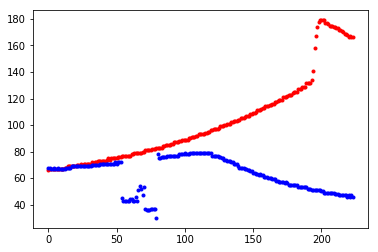

In [15]:
graph_x=train_depth[0][10,:]
graph_y=train_depth[0][:,10]
plt.plot(graph_x,'r.')
plt.plot(graph_y,'b.')
plt.show()

In [16]:
for i in range(train_num):
    plt.imsave('seg_out'+version+'/output_img-'+str(i+1).zfill(6)+'_st.jpg',im_resize(cv2.imread('img_data/train_label/img-'+str(i+1).zfill(6)+'.png',0),img_size))
for i in range(test_num):
    plt.imsave('seg_out'+version+'/test_image/test_img-'+str(i+1).zfill(6)+'_st.png',im_resize(cv2.imread('img_data/test_label/img-'+str(i+1).zfill(6)+'.png',0),img_size))
for i in range(train_num):
    plt.imsave('seg_out'+version+'/output_img-'+str(i+1).zfill(6)+'_dt.jpg',d_resize(cv2.imread('img_data/train_depth/img-'+str(i+1).zfill(6)+'.png',0),img_size))
for i in range(test_num):
    plt.imsave('seg_out'+version+'/test_image/test_img-'+str(i+1).zfill(6)+'_dt.png',d_resize(cv2.imread('img_data/test_depth/img-'+str(i+1).zfill(6)+'.png',0),img_size))

In [16]:
training_epochs=400
tf.reset_default_graph()
x=tf.placeholder(tf.float32,[None,h,w,3]) 
s=tf.placeholder(tf.float32, [None,h,w,c])
d=tf.placeholder(tf.float32, [None,h,w,1])
keep_prob=tf.placeholder(tf.float32)
train_type=tf.placeholder(tf.bool)
global_step = tf.placeholder(tf.float32)
d_deri=tf.constant([[-1,0,1], [-2,0,2], [-1,0,1]], tf.float32)
s_deri=tf.constant([[1,1,1], [1,0,1], [1,1,1]], tf.float32)

In [17]:
class Vgg16:
    def __init__(self, vgg16_npy_path=None):
        if vgg16_npy_path is None:
#             path = inspect.getfile(Vgg16)
#             path = os.path.abspath(os.path.join(path, os.pardir))
#             path = os.path.join(path, "vgg16.npy")
            path="vgg16.npy"
            vgg16_npy_path = path
            print(path)
        self.VGG_MEAN = [103.939, 116.779, 123.68]
        self.data_dict = np.load(vgg16_npy_path, encoding='latin1').item()
        self.IS_T=train_type
        print("npy file loaded")

    def build(self, rgb,size):
        rgb_scaled = rgb * 255.0

        # Convert RGB to BGR
        red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=rgb_scaled)
        assert red.get_shape().as_list()[1:] == [size, size, 1]
        assert green.get_shape().as_list()[1:] == [size, size, 1]
        assert blue.get_shape().as_list()[1:] == [size, size, 1]
        bgr = tf.concat(axis=3, values=[
            blue - self.VGG_MEAN[0],
            green - self.VGG_MEAN[1],
            red - self.VGG_MEAN[2],
        ])
        assert bgr.get_shape().as_list()[1:] == [size, size, 3]

        self.conv1_1 = self.conv_layer(bgr, "conv1_1")
        self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
        self.pool1 = self.max_pool(self.conv1_2, 'pool1')

        self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
        self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
        self.pool2 = self.max_pool(self.conv2_2, 'pool2')

        self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
        self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
        self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
        self.pool3 = self.max_pool(self.conv3_3, 'pool3')

        self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
        self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
        self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
        self.pool4 = self.max_pool(self.conv4_3, 'pool4')

        self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
        self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
        self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
        return self.conv1_2, self.conv2_2, self.conv3_3, self.conv4_3, self.conv5_3

    def max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def conv_layer(self, bottom, name):
        with tf.variable_scope(name):
            filt = self.get_conv_filter(name)

            conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')

            conv_biases = self.get_bias(name)
            bias = tf.nn.bias_add(conv, conv_biases)

            relu = act_func_c(bias,self.IS_T)
            return relu

    def get_conv_filter(self, name):
        return tf.constant(self.data_dict[name][0], name="filter")

    def get_bias(self, name):
        return tf.constant(self.data_dict[name][1], name="biases")

In [18]:
vgg=Vgg16()
l_c_1_2, l_c_2_2, l_c_3_3, l_c_4_3, l_c_5_3=vgg.build(x,img_size)

vgg16.npy
npy file loaded


In [19]:
print(l_c_1_2)
print(l_c_2_2)
print(l_c_3_3)
print(l_c_4_3)
print(l_c_5_3)

Tensor("conv1_2/Relu:0", shape=(?, 224, 224, 64), dtype=float32)
Tensor("conv2_2/Relu:0", shape=(?, 112, 112, 128), dtype=float32)
Tensor("conv3_3/Relu:0", shape=(?, 56, 56, 256), dtype=float32)
Tensor("conv4_3/Relu:0", shape=(?, 28, 28, 512), dtype=float32)
Tensor("conv5_3/Relu:0", shape=(?, 14, 14, 512), dtype=float32)


In [20]:
l_c_4_a,_=get_conv(l_c_4_3,1,512,256,2,'c_4_a', train_type)
l_c_4_a=tf.layers.dropout(l_c_4_a,rate=keep_prob)

l_c_3_a,_=get_conv(l_c_3_3,1,256,128,2,'c_3_a', train_type)
l_c_3_a=tf.layers.dropout(l_c_3_a,rate=keep_prob)

l_c_2_a,_=get_conv(l_c_2_2,1,128,128,2,'c_2_a', train_type)
l_c_2_a=tf.layers.dropout(l_c_2_a,rate=keep_prob)

l_c_1_a,_=get_conv(l_c_1_2,1,64,128,2,'c_1_a', train_type)
l_c_1_a=tf.layers.dropout(l_c_1_a,rate=keep_prob)

In [21]:
l_dep_5,_=get_conv(l_c_5_3,3,512,1024,3,'dep_5',train_type)

l_dep_4=dep_deconv(l_dep_5, 3, math.ceil(h/8),l_c_4_a,256,1024,512,'dep_4', train_type)
l_dep_4=tf.layers.dropout(l_dep_4,rate=keep_prob)

l_dep_3=dep_deconv(l_dep_4, 3, math.ceil(h/4),l_c_3_a,128,512,256,'dep_3', train_type)
l_dep_3=tf.layers.dropout(l_dep_3,rate=keep_prob)

l_dep_2=dep_deconv(l_dep_3, 3, math.ceil(h/2),l_c_2_a,128,256,128,'dep_2', train_type)
l_dep_2=tf.layers.dropout(l_dep_2,rate=keep_prob)


l_dep_1=dep_deconv(l_dep_2, 3, h,l_c_1_a,128,128,64,'dep_1', train_type)
l_dep_1=tf.layers.dropout(l_dep_1,rate=keep_prob)

In [22]:
l_seg_5,_=get_conv(l_c_5_3,1,512,1024,2,'seg_5',train_type)

l_seg_4=seg_deconv(l_seg_5, 3, math.ceil(h/8),l_c_4_a,256,1024,512,'seg_4', train_type)
l_seg_4=tf.layers.dropout(l_seg_4,rate=keep_prob)

l_seg_3=seg_deconv(l_seg_4, 3, math.ceil(h/4),l_c_3_a,128,512,256,'seg_3', train_type)
l_seg_3=tf.layers.dropout(l_seg_3,rate=keep_prob)

l_seg_2=seg_deconv(l_seg_3, 3, math.ceil(h/2),l_c_2_a,128,256,128,'seg_2', train_type)
l_seg_2=tf.layers.dropout(l_seg_2,rate=keep_prob)


l_seg_1=seg_deconv(l_seg_2, 3, h,l_c_1_a,128,128,128,'seg_1', train_type)
l_seg_1=tf.layers.dropout(l_seg_1,rate=keep_prob)

In [23]:
l_dns_1,_=get_conv(l_dep_1,3,64,64,5,'dns_1',train_type)
l_snd_1,_=get_conv(l_seg_1,3,128,128,3,'snd_1',train_type)

In [24]:
l_snd_a,_=get_conv(l_snd_1,1,128,128,2,'snd_a',train_type)

In [25]:
w_dns,b_dns=make_wei("dns",3,64,1)
w_snd,b_snd=make_wei("snd",1,128,c)

In [26]:
l_dns=tf.nn.conv2d(l_dns_1,w_dns, strides=[1,1,1,1], padding= 'SAME')+b_dns
l_snd=tf.nn.conv2d(l_snd_a,w_snd, strides=[1,1,1,1], padding= 'SAME')+b_snd

In [27]:
l_dns_0,_=get_conv(l_dns,3,1,64,2,'dns_0',train_type)
l_snd_0,_=get_conv(l_snd,3,c,128,2,'snd_0',train_type)

In [28]:
l_dep_0=tf.concat([l_dns,l_snd_0],3)
l_seg_0=tf.concat([l_snd,l_dns_0],3)
l_dep_f,_=get_conv(l_dep_0,3,128+1,64,7,'dep_f',train_type)
l_seg_f,_=get_conv(l_seg_0,3,64+c,128,5,'seg_f',train_type)

In [29]:
l_seg_fc,_=get_conv(l_seg_f,1,128,128,2,'seg_fc',train_type)

In [30]:
w_dep,b_dep=make_wei("dep",3,64,1)
w_seg,b_seg=make_wei("seg",1,128,c)

In [31]:
l_dep=tf.nn.conv2d(l_dep_f,w_dep, strides=[1,1,1,1], padding= 'SAME')+b_dep

l_seg=tf.nn.conv2d(l_seg_fc,w_seg, strides=[1,1,1,1], padding= 'SAME')+b_seg

In [32]:
flat_output=tf.reshape(l_seg,[-1,c])
flat_output_snd=tf.reshape(l_snd,[-1,c])
flat_s=tf.reshape(s,[-1,c])
s_avg=tf.nn.avg_pool(s, ksize=[1,5,5,1], strides=[1,1,1,1], padding='SAME')
flat_s_avg=tf.reshape(s_avg,[-1,c])

In [33]:
# seg_cost_1=tf.nn.sigmoid_cross_entropy_with_logits(logits=l_seg,labels=s)
# seg_cost_1=tf.reduce_sum(seg_cost_1,3)
# seg_cost_1=tf.reshape(seg_cost_1,[-1,h*w])
# seg_cost_1=tf.reduce_mean(seg_cost_1,1)
# seg_cost_1=tf.reduce_mean(seg_cost_1)

In [34]:
seg_cost_1=tf.nn.softmax_cross_entropy_with_logits(logits=l_seg,labels=s)
seg_cost_1=tf.reshape(seg_cost_1,[-1,h*w])
seg_cost_1=tf.reduce_mean(seg_cost_1,1)
seg_cost_1=tf.reduce_mean(seg_cost_1)

In [35]:
# seg_cost_2=tf.nn.sigmoid_cross_entropy_with_logits(logits=l_seg,labels=s_avg)
# seg_cost_2=tf.reduce_sum(seg_cost_2,3)
# seg_cost_2=tf.reshape(seg_cost_2,[-1,h*w])
# seg_cost_2=tf.reduce_mean(seg_cost_2,1)
# seg_cost_2=tf.reduce_mean(seg_cost_2)

In [36]:
# seg_cost=tf.nn.sigmoid_cross_entropy_with_logits(logits=flat_output,labels=flat_s_avg)
# seg_cost=tf.reshape(seg_cost,[-1,h*w])
# seg_cost=tf.reduce_mean(tf.exp(seg_cost),1)
# seg_cost=tf.reduce_mean(seg_cost)

In [37]:
flat_d=tf.reshape(d,[-1,h*w])
flat_l_dep=tf.reshape(l_dep,[-1,h*w])

In [38]:
d_sub=tf.square(flat_d-flat_l_dep)
dep_cost_1=tf.reduce_mean(d_sub,1)
dep_cost_1=tf.reduce_mean(dep_cost_1)

In [39]:
s_image_2=tf.argmax(l_seg,3)
d_image_2=tf.reshape(l_dep,[-1,h,w])

s_image_1=tf.argmax(l_snd,3)
d_image_1=tf.reshape(l_dns,[-1,h,w])

In [40]:
inter_1,label_1,union_1=acc(flat_output,flat_s)
inter_2,label_2,union_2=acc(flat_output_snd,flat_s)

In [41]:
def dep_deri(dep_img):
    d_x_deri = tf.reshape(d_deri, [3, 3, 1, 1])
    d_y_deri = tf.transpose(d_x_deri, [1, 0, 2, 3])
    

    d_x_deri=tf.nn.conv2d(dep_img, d_x_deri, strides=[1, 1, 1, 1], padding='VALID')
    d_y_deri=tf.nn.conv2d(dep_img, d_y_deri, strides=[1, 1, 1, 1], padding='VALID')

    
    d_x_loss=tf.abs(d_x_deri/2.0)
    d_y_loss=tf.abs(d_y_deri/2.0)
    
        
    dep_x_cost=tf.reshape(d_x_loss,[-1,int(d_x_loss.shape[1])*int(d_x_loss.shape[2])])
    dep_y_cost=tf.reshape(d_y_loss,[-1,int(d_y_loss.shape[1])*int(d_y_loss.shape[2])])
    dep_deri_cost=tf.reduce_mean(tf.reduce_mean(dep_x_cost,1)+tf.reduce_mean(dep_y_cost,1))
    
    return dep_deri_cost

In [42]:
dep_deri_cost=dep_deri(l_dep)
dns_deri_cost=dep_deri(l_dns)

In [43]:
dep_sub_1=tf.square((l_dns-d)/2.0)
dep_sub_2=1-tf.exp(-dep_sub_1)

s_dep=s*dep_sub_2

seg_cost_3=tf.nn.sigmoid_cross_entropy_with_logits(logits=l_snd,labels=s_dep)
seg_cost_3=tf.reshape(seg_cost_3,[-1,h*w,c])
seg_cost_3=tf.reduce_sum(seg_cost_3,2)
seg_cost_3=tf.reshape(seg_cost_3,[-1,h*w])
seg_cost_3=tf.reduce_mean(seg_cost_3,1)
seg_cost_3=tf.reduce_mean(seg_cost_3)

In [44]:
s_soft=tf.nn.softmax(l_snd*0.01)*s
seg_f_1_cost=tf.reduce_sum(s_soft,3)
seg_f_2_cost=1.0-tf.reshape(seg_f_1_cost,[-1,h,w,1])

dep_cost_2=seg_f_2_cost*dep_sub_1

# dep_cost_2=tf.reduce_mean(dep_cost_2,1)
# dep_cost_2=tf.reduce_mean(dep_cost_2)

In [45]:
s_con=tf.reshape(seg_f_2_cost,[-1,h,w])
d_con=tf.reshape(dep_sub_2,[-1,h,w])

In [46]:
flat_l_dns=tf.reshape(l_dns,[-1,h*w])
dns_cost=tf.reduce_mean(tf.square(flat_d-flat_l_dns),1)
dns_cost=tf.reduce_mean(dns_cost)

In [47]:
snd_cost=tf.nn.softmax_cross_entropy_with_logits(logits=l_snd,labels=s)
snd_cost=tf.reshape(snd_cost,[-1,h*w])
snd_cost=tf.reduce_mean(snd_cost,1)
snd_cost=tf.reduce_mean(snd_cost)

In [48]:
# dep_cost=(dep_cost_1*0.6)+(dep_cost_2*0.4)+(dep_deri_cost*0.4)+((dns_cost*0.6)+(dns_deri_cost*0.4))*0.8
dep_cost=(dep_cost_1*0.6)+(dep_deri_cost*0.4)+((dns_cost*0.6)+(dns_deri_cost*0.4))*0.8

In [49]:
# seg_cost=seg_cost_1+seg_cost_2+(seg_cost_3*0.6)
seg_cost=(seg_cost_1)+(seg_cost_3*0.6)+(snd_cost*0.8)

In [50]:
# dep_sub_1=tf.square(l_dep-d)
# dep_sub_2=tf.exp(-dep_sub_1)
# seg_soft=tf.nn.softmax(l_seg)
# dep_sub_3=(dep_sub_2+seg_soft)/2.0
# dep_sub_4=dep_sub_3*s

# dep_seg_cost_1=tf.reduce_sum(dep_sub_4,3)
# dep_seg_cost_1=tf.reshape(dep_seg_cost_1,[-1,h*w])
# dep_seg_cost_1=tf.reduce_mean(dep_seg_cost_1,1)
# dep_seg_cost=tf.reduce_mean(dep_seg_cost_1)

In [51]:
# cost=seg_cost*0.9+dep_cost*0.8+dep_seg_cost*0.3
cost=(seg_cost*0.8)+(dep_cost*0.5)
starter_learning_rate = 0.0001
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,50, 0.5, staircase=True)
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [52]:
# starter_learning_rate_s = 0.0001
# learning_rate_s = tf.train.exponential_decay(starter_learning_rate_s, global_step,30, 0.1, staircase=True)
# optimizer_s=tf.train.AdamOptimizer(learning_rate=learning_rate_s).minimize(seg_cost)

In [53]:
# starter_learning_rate_d = 0.0001
# learning_rate_d = tf.train.exponential_decay(starter_learning_rate_d, global_step,30, 0.1, staircase=True)
# optimizer_d=tf.train.AdamOptimizer(learning_rate=learning_rate_d).minimize(dep_cost)

In [ ]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())
saver=tf.train.Saver()
# saver.restore(sess,"seg_out"+version+"/seg_model.ckpt")
print("Learning start")

for epoch in range(training_epochs):
    a=0
    batch_size=2
    total_batch = math.ceil(len(train_image)/batch_size)
    start=time.time()
    avg_d_cost=0
    avg_s_cost=0
    avg_dns_cost=0
    avg_snd_cost=0
    
    avg_inter_1=np.zeros((c))
    avg_gt_1=np.zeros((c))
    avg_union_1=np.zeros((c))
    avg_inter_2=np.zeros((c))
    avg_gt_2=np.zeros((c))
    avg_union_2=np.zeros((c))
    
   
    

    for i in range(total_batch):
        if a+batch_size>len(train_image):
            batch_xs=train_image[a:]
            batch_ys=train_label[a:]
            batch_ds=train_depth[a:]
        else:
            batch_xs=train_image[a:a+batch_size]
            batch_ys=train_label[a:a+batch_size]
            batch_ds=train_depth[a:a+batch_size]
        
        feed_dict={x:batch_xs, s:batch_ys, d:batch_ds, keep_prob:0.6, train_type:True, global_step:epoch}
        dep_con,seg_con,rate,d_img_1,d_img_2,d_c,dns_c,s_img_1,s_img_2,s_c,snd_c,_=sess.run([d_con,s_con,learning_rate,d_image_1,d_image_2,dep_cost_1,dns_cost,s_image_1,s_image_2,seg_cost_1,snd_cost,optimizer], feed_dict=feed_dict)
        in_1,gt_1,un_1,in_2,gt_2,un_2=sess.run([inter_1,label_1,union_1,inter_2,label_2,union_2], feed_dict=feed_dict)
#         rate_d,d_img,d_c,_,rate_s,in_1,gt_1,un_1,s_img,s_c,_=sess.run([learning_rate_d,d_image,dep_cost,optimizer_d,learning_rate_s,inter,label,union,s_image,seg_cost,optimizer_s], feed_dict=feed_dict)
#         rate_s,in_1,gt_1,un_1,s_img,s_c,_=sess.run([learning_rate_s,inter,label,union,s_image,seg_cost,optimizer_s], feed_dict=feed_dict)
        for j in range(len(batch_xs)):
            plt.imsave('seg_out'+version+'/output_img-'+str(a+j+1).zfill(6)+'_se_1.jpg',s_img_1[j])
            plt.imsave('seg_out'+version+'/output_img-'+str(a+j+1).zfill(6)+'_de_1.jpg',d_img_1[j])
            plt.imsave('seg_out'+version+'/output_img-'+str(a+j+1).zfill(6)+'_se_2.jpg',s_img_2[j])
            plt.imsave('seg_out'+version+'/output_img-'+str(a+j+1).zfill(6)+'_de_2.jpg',d_img_2[j])
            plt.imsave('seg_out'+version+'/conf_map/'+str(a+j+1).zfill(6)+'_dep.png',dep_con[j])
            plt.imsave('seg_out'+version+'/conf_map/'+str(a+j+1).zfill(6)+'_seg.png',seg_con[j])
            
        a=a+batch_size
        avg_s_cost+=s_c
        avg_d_cost+=d_c
        avg_snd_cost+=snd_c
        avg_dns_cost+=dns_c
        

        avg_inter_1+=in_1
        avg_gt_1+=gt_1
        avg_union_1+=un_1
        
        avg_inter_2+=in_2
        avg_gt_2+=gt_2
        avg_union_2+=un_2

    print("epoch : ", epoch)
    print("seg_cost : ", '{:.5f}'.format(avg_s_cost/total_batch),"snd_cost : ", '{:.5f}'.format(avg_snd_cost/total_batch),"dep_cost : ",'{:.5f}'.format(avg_d_cost/total_batch),"dns_cost : ", '{:.5f}'.format(avg_dns_cost/total_batch))
    print("\n")
    s_iou_1,s_mean_1,m_iou_1,m_mean_1=iou_mean(avg_inter_1,avg_union_1,avg_gt_1,c)
    s_iou_2,s_mean_2,m_iou_2,m_mean_2=iou_mean(avg_inter_2,avg_union_2,avg_gt_2,c)
    

        
    saver.save(sess, "seg_out"+version+"/seg_model.ckpt")
    end=time.time()
    print(end-start)
    print("\n")
    
    if epoch%2==0:
        test_a=0
        test_batch_size=2
        test_total_batch = int(math.ceil(len(test_image)/test_batch_size))
        test_avg_snd_cost=0
        test_avg_dns_cost=0
        test_avg_s_cost=0
        test_avg_d_cost=0
        
        test_avg_inter_1=np.zeros((c))
        test_avg_gt_1=np.zeros((c))
        test_avg_union_1=np.zeros((c))
        test_avg_inter_2=np.zeros((c))
        test_avg_gt_2=np.zeros((c))
        test_avg_union_2=np.zeros((c))


        for i in range(test_total_batch):
            if test_a+batch_size>len(test_image):
                test_batch_xs=test_image[test_a:]
                test_batch_ys=test_label[test_a:]
                test_batch_ds=test_depth[test_a:]
            else:
                test_batch_xs=test_image[test_a:test_a+test_batch_size]
                test_batch_ys=test_label[test_a:test_a+test_batch_size]
                test_batch_ds=test_depth[test_a:test_a+test_batch_size]
                
                
            test_feed_dict={x:test_batch_xs, s:test_batch_ys, d:test_batch_ds, keep_prob:1.0,train_type:False,global_step:epoch}
            t_dep_con,t_seg_con,t_s_img_1,t_s_img_2,t_d_img_1,t_d_img_2,t_s_c,t_d_c,t_snd_c,t_dns_c=sess.run([d_con,s_con,s_image_1,s_image_2,d_image_1,d_image_2, seg_cost_1,dep_cost_1,snd_cost,dns_cost], feed_dict=test_feed_dict)
            t_in_1,t_gt_1,t_un_1,t_in_2,t_gt_2,t_un_2=sess.run([inter_1,label_1,union_1,inter_2,label_2,union_2], feed_dict=test_feed_dict)
            for k in range(len(test_batch_xs)):
                plt.imsave('seg_out'+version+'/test_image/test_img-'+str(test_a+k+1).zfill(6)+'_se_1.png',t_s_img_1[k])
                plt.imsave('seg_out'+version+'/test_image/test_img-'+str(test_a+k+1).zfill(6)+'_de_1.png',t_d_img_1[k])
                plt.imsave('seg_out'+version+'/test_image/test_img-'+str(test_a+k+1).zfill(6)+'_se_2.png',t_s_img_2[k])
                plt.imsave('seg_out'+version+'/test_image/test_img-'+str(test_a+k+1).zfill(6)+'_de_2.png',t_d_img_2[k])
                plt.imsave('seg_out'+version+'/test_conf_map/'+str(test_a+k+1).zfill(6)+'_dep.png',t_dep_con[k])
                plt.imsave('seg_out'+version+'/test_conf_map/'+str(test_a+k+1).zfill(6)+'_seg.png',t_seg_con[k])
                
            test_a=test_a+test_batch_size

            test_avg_s_cost+=t_s_c
            test_avg_d_cost+=t_d_c
            test_avg_snd_cost+=t_snd_c
            test_avg_dns_cost+=t_dns_c
            
            test_avg_inter_1+=t_in_1
            test_avg_gt_1+=t_gt_1
            test_avg_union_1+=t_un_1
            
            test_avg_inter_2+=t_in_2
            test_avg_gt_2+=t_gt_2
            test_avg_union_2+=t_un_2
            
        print("\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\ test_network \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\")
        print("seg_cost : ",'{:.5f}'.format(test_avg_s_cost/test_total_batch), "dep_cost : ",'{:.5f}'.format(test_avg_d_cost/test_total_batch),"snd_cost : ",'{:.5f}'.format(test_avg_snd_cost/test_total_batch),"dns_cost : ",'{:.5f}'.format(test_avg_dns_cost/test_total_batch))
        test_s_iou_1,test_s_mean_1,test_m_iou_1,test_m_mean_1=iou_mean(test_avg_inter_1,test_avg_union_1,test_avg_gt_1,c)
        test_s_iou_2,test_s_mean_2,test_m_iou_2,test_m_mean_2=iou_mean(test_avg_inter_2,test_avg_union_2,test_avg_gt_2,c)
        print("\n")
        
        if epoch%6==0:
            print("train_iou_1")
            print(s_iou_1)
            print("train_mean_1")
            print(s_mean_1)
            print("test_iou_1")
            print(test_s_iou_1)
            print("test_mean_1")
            print(test_s_mean_1)
            print("\n")
            
            print("train_iou_snd")
            print(s_iou_2)
            print("train_mean_snd")
            print(s_mean_2)
            print("test_iou_snd")
            print(test_s_iou_2)
            print("test_mean_snd")
            print(test_s_mean_2)
            print("\n")
    if epoch%8==0:
        feed_dict={x:batch_xs, s:batch_ys, d:batch_ds, keep_prob:1.0, train_type:True, global_step:epoch}
        e_i_1,e_i_2,e_i_3,e_i_4,e_i_5=sess.run([l_c_1_2,l_c_2_2,l_c_3_3,l_c_4_3,l_c_5_3], feed_dict=feed_dict)
        for q in range(64):
            plt.imsave('seg_out'+version+'/edge_map/edge_map_1_'+str(q).zfill(2)+'.png',e_i_1[0,:,:,q])
            plt.imsave('seg_out'+version+'/edge_map/edge_map_2_'+str(q).zfill(2)+'.png',e_i_2[0,:,:,q])
            plt.imsave('seg_out'+version+'/edge_map/edge_map_3_'+str(q).zfill(2)+'.png',e_i_3[0,:,:,q])
            plt.imsave('seg_out'+version+'/edge_map/edge_map_4_'+str(q).zfill(2)+'.png',e_i_4[0,:,:,q])
            plt.imsave('seg_out'+version+'/edge_map/edge_map_5_'+str(q).zfill(2)+'.png',e_i_5[0,:,:,q])
       

Learning start
epoch :  0
seg_cost :  3.43803 snd_cost :  127.08371 dep_cost :  1556.84317 dns_cost :  47803.02912


mean_iou_acc :  0.069916687
mean_mean_acc :  0.123250494
mean_iou_acc :  0.073039785
mean_mean_acc :  0.125440382
945.5108668804169


\\\\\\\\\\\\\\\\\\\ test_network \\\\\\\\\\\\\\\\\\\
seg_cost :  2.17889 dep_cost :  1802.84887 snd_cost :  28.91513 dns_cost :  4767.80160
mean_iou_acc :  0.018508502
mean_mean_acc :  0.071561898
mean_iou_acc :  0.036734822
mean_mean_acc :  0.082749959


train_iou_1
[  2.38500063e-01   1.68551082e-01   1.91215035e-04   3.33425353e-02
   4.64175640e-02   2.20209601e-01   1.99756102e-03   1.11565775e-04
   1.54047335e-03   1.06277213e-03   3.24091846e-02   9.43637859e-05
   2.20673388e-01   1.37322512e-02]
train_mean_1
[  5.61817587e-01   2.43446843e-01   2.67558528e-04   4.67464103e-02
   6.02480228e-02   3.42217413e-01   2.07765631e-03   1.11950448e-04
   2.42883425e-03   1.11203311e-03   4.30523934e-02   1.80766450e-04
   4.04802409e-01 